In [2]:
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_columns',None)
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=True)

In [3]:
raw_data = pd.read_csv(
    'mtsamples.csv',
    usecols = [
        'description',
        'medical_specialty',
        'sample_name',
        'transcription',
        'keywords'
    ]
)
print(raw_data.shape)
raw_data.head()

(4999, 5)


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


### Data understanding
This data is from mtsamples.com which has open source medical transcriptions.

__description__ seems to be a short description of the medical transcription or the reason for the encounter.

In [4]:
# title/description of transcription
raw_data.description.iloc[0]

' A 23-year-old white female presents with complaint of allergies.'

__medical_specialty__ is self explanatory.

In [5]:
# mtsamples.com category
raw_data.medical_specialty.iloc[0]

' Allergy / Immunology'

I'm unsure of __sample_name__. It seems to have some similarity to __description__. I probably will not use this column due to lack of understanding.

In [6]:
# Unsure
raw_data.sample_name.iloc[0]

' Allergic Rhinitis '

__transcription__ is the meat of the medical transcription. As far as I can tell, these are the doctor's notes.

In [7]:
# raw transcription text
raw_data.transcription.iloc[0]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

__keywords__ seem to be extracted keywords someone has previously found.

In [8]:
# extracted keywords
raw_data.keywords.iloc[0]

'allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,'

__keywords__ has a significant null portion.

In [11]:
raw_data.isnull().sum()

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

### Goal
For this exercise, I will perform topic modeling on the __transcription__ column. Features like __description__ and __sample_name__ have text that is too short. __keywords__ is already a text analytics product. __medical_specialty__ is somewhat like what I am attempting to create. It is not perfect for a medical lamen, but I will aim for higher level categories that I do understand like cancer, orthopedics, surgery, etc.

__medical_specialty__ is dominated by 'Surgery' and paitent consults in second. I assume these will be clearly clustered given the types of words involved. 

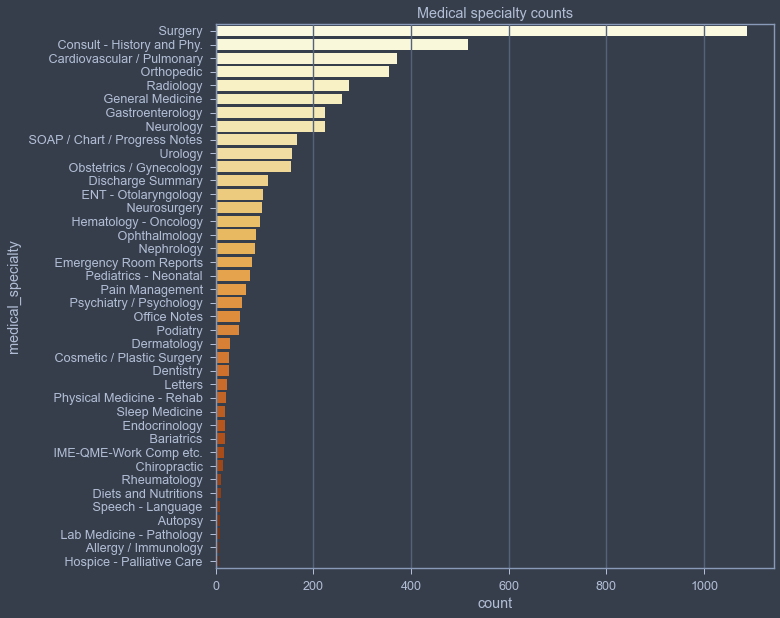

In [54]:
sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(10,10))
sns.countplot(
    y=raw_data.medical_specialty,
    order=raw_data.medical_specialty.value_counts().index,
    palette='YlOrBr'
)
plt.title('Medical specialty counts')
plt.show()

In [12]:
raw_data.dropna(subset=['transcription'], inplace=True)

### Data cleaning

In [13]:
# define text cleaning function
def cleaning(text) -> list:
    """
    comment/uncomment regular/tweet cleaning regexes depending on needs
    """
    # load language model
    nlp = spacy.load('en_core_web_lg', 
#                      disable=['ner', 'parser']
                    )
    # add to stopwords
    nlp.Defaults.stop_words.add('rt')
    # create spacy doc
    doc = nlp(text)
    # combined regexes for tweet cleaning
    regexes_combined = 'http://\\S+|https://\\S+|@[^\\s]+|#|[^A-Za-z]+'
    clean_words = list(
        filter(
            lambda word: len(word) > 1 # filter single letter tokens
            or 
            None, # filter empty strings
            ## regular text cleaning - use regexes, lemmatize, lowercase, remove stopwords
            [re.sub('[^A-Za-z]+', '', word.lemma_.lower()) for word in doc if not word.is_stop]
            ## tweet cleaning - regular text cleaning + remove hyperlinks/usernames/#'s
#             [re.sub(regexes_combined, '', word.lemma_.lower()) for word in doc if not word.is_stop]
        )
    )
            
    return clean_words

Since I was on a business trip while doing this work, I needed to ensure I wouldn't lose my work. As done previously, I took the time to clean the text and saved the data to HDF. Since I've restarted since then, I am simple loading to file with Pandas.

In [14]:
# clean_text = []
# for d in tqdm(raw_data.transcription): 
#     clean_text.append(cleaning(d))

In [35]:
# df = raw_data[['transcription','medical_specialty']].copy()
# df['clean_transcription'] = clean_text
# df.head()

In [23]:
# df.to_hdf('wk8_cleaned_data.h5', key='df', mode='w')

In [17]:
df = pd.read_hdf('wk8_cleaned_data.h5', key='df', mode='r')
df.head()

,transcription,medical_specialty,clean_transcription
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,"[subjective, year, old, white, female, present..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics,"[past, medical, history, difficulty, climb, st..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics,"[history, present, illness, see, abc, today, p..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary,"[mode, left, atrial, enlargement, left, atrial..."
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,"[left, ventricular, cavity, size, wall, thickn..."


### Medical specialty word frequencies
In an ideal word, my clusters top words would be similar to these 40 medical specialties.

In [46]:
for specialty in df.medical_specialty.unique():
    freqs = (
        Counter(
            x for sublist in df.clean_transcription[df.medical_specialty == specialty] 
            for x in sublist
        ).most_common()[:20]
    )
    print(specialty)
    print(freqs)
    print()

 Allergy / Immunology
[('history', 38), ('allergy', 25), ('patient', 25), ('note', 25), ('past', 13), ('nasal', 13), ('masse', 12), ('bilaterally', 12), ('time', 11), ('asthma', 11), ('clear', 11), ('medical', 11), ('normal', 11), ('year', 10), ('allergic', 10), ('treatment', 10), ('acute', 10), ('lesion', 10), ('daily', 9), ('medication', 9)]

 Bariatrics
[('patient', 63), ('history', 50), ('weight', 36), ('surgery', 35), ('include', 30), ('year', 30), ('gastric', 30), ('abdomen', 27), ('procedure', 26), ('bypass', 25), ('pain', 24), ('loss', 24), ('obesity', 23), ('place', 23), ('need', 22), ('week', 21), ('past', 19), ('pound', 19), ('disease', 18), ('mg', 18)]

 Cardiovascular / Pulmonary
[('patient', 1664), ('right', 1298), ('artery', 1172), ('left', 1113), ('coronary', 683), ('procedure', 661), ('history', 650), ('normal', 646), ('chest', 546), ('place', 510), ('catheter', 495), ('mg', 454), ('pressure', 436), ('heart', 435), ('leave', 434), ('pulmonary', 427), ('disease', 410), 

Below is a quick list of words I've found which do not aid in differentiating topics. Therefore I create a second __clean_transcription__ column with the edited texts.

In [43]:
new_stopwords = [
    'patient',
    'history',
    'mm dd',
    'dd',
    'dd yyyy',
    'yyyy',
    'right',
    'left'
]

df['clean_transcription2'] = (
    df['clean_transcription']
    .apply(
    lambda row: 
        [val for val in row if val not in new_stopwords]
)
                    )

### Topic modeling

In [25]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [26]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

I want to test more than one type of topic modeling. To be specific, I am going to look at topics in non-negative matrix factorization (Frobenius norm), non-negative matrix factorization (generalized Kullback-Leibler divergence), and LDA.

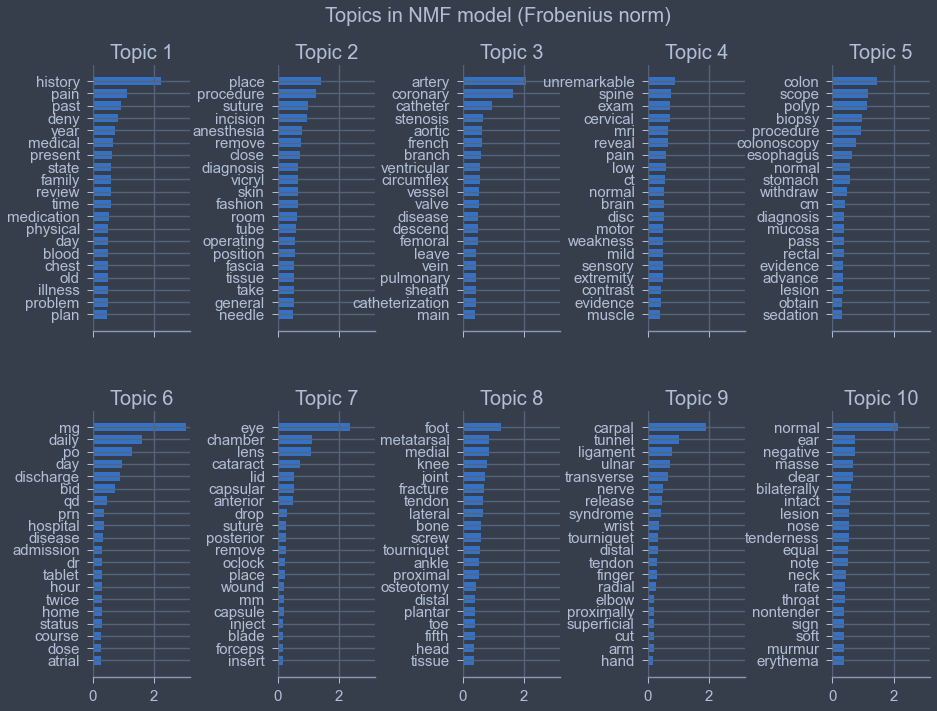

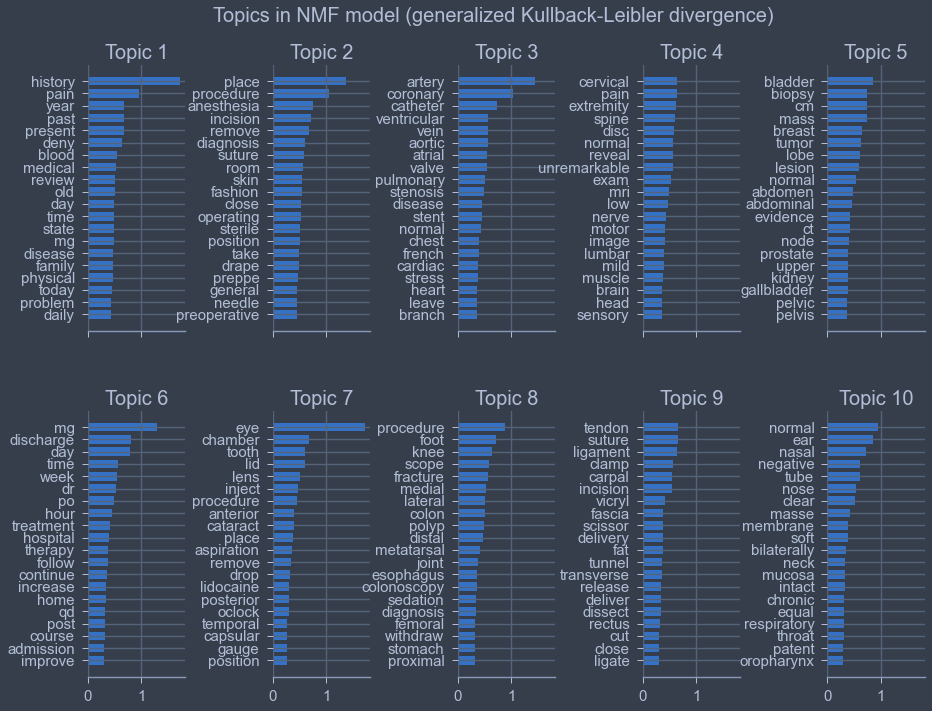

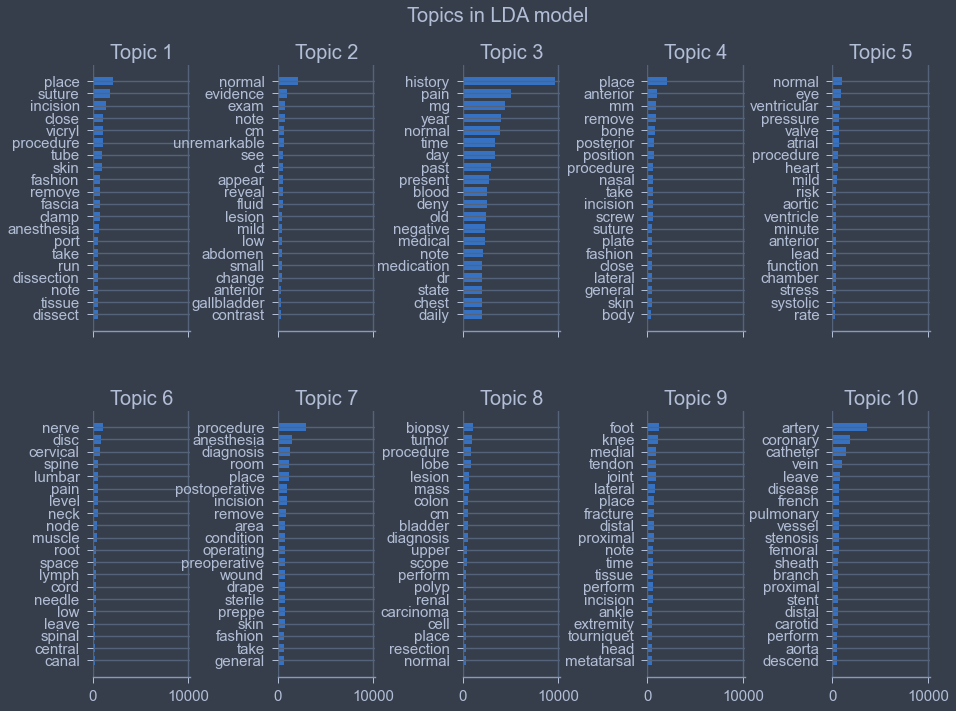

Wall time: 29.9 s


In [30]:
%%time
n_features = 1000
n_components = 10
n_top_words = 20

prepped_text = df.clean_transcription2.apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, 
    min_df=2, 
    max_features=n_features, 
)

tfidf = tfidf_vectorizer.fit_transform(prepped_text)

tf_vectorizer = CountVectorizer(
    max_df=0.95, 
    min_df=2, 
    max_features=n_features, 
)

tf = tf_vectorizer.fit_transform(prepped_text)

nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### Results
You can see somewhat similar topics between models. I personally find LDA to be the best. My (lamens) take on the LDA topics are:
  + __Topic 1__: surgery
  + __Topic 2__: medical imaging
  + __Topic 3__: patient history
  + __Topic 4__: condition/injury positioning
  + __Topic 5__: cardiovascular - blood pressure
  + __Topic 6__: spine
  + __Topic 7__: surgery (again)
  + __Topic 8__: oncology
  + __Topic 9__: orthopedics/podiatry
  + __Topic 10__: cardiovascular - heart